# Chapter 11: Dense Vector Representations
Training embeddings: The GloVe algorithm

Reference: Pennington, J., Socher, R., and Manning, C. (2014). Glove: Global vectors for word representation. In _Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP)_, pages 1532–1543, Doha.

Note that using GloVe's original embedding initialization will reduce the training time

Programs from the book: [_Python for Natural Language Processing_](https://link.springer.com/book/9783031575488)

__Author__: Pierre Nugues

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import os
import regex as re
from collections import Counter
import collections
from math import log
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
d = torch.tensor(50)  # Embedding size
K = 4  # context window
BATCH_SIZE = 512
EPOCHS = 20
alpha = torch.tensor(0.75)
x_max = torch.tensor(100.)
STD_DEV = 1./torch.sqrt(d)  # 0.01 #1./torch.sqrt(d)
torch.manual_seed(1234)

## Corpus Files

We read the files and we store the corpus in a string

In [3]:
PATH = '../datasets/'

In [4]:
CORPUS = 'HOMER'  # 'DICKENS'

In [5]:
if CORPUS == 'DICKENS':
    folder = PATH + 'dickens/'
elif CORPUS == 'HOMER':
    folder = PATH + 'classics/'

In [6]:
def get_files(dir, suffix):
    """
    Returns all the files in a folder ending with suffix
    :param dir:
    :param suffix:
    :return: the list of file names
    """
    files = []
    for file in os.listdir(dir):
        if file.endswith(suffix):
            files.append(file)
    return files

In [7]:
if CORPUS == 'DICKENS':
    files = get_files(folder, 'txt')
elif CORPUS == 'HOMER':
    files = ['iliad.txt', 'odyssey.txt']
files

['iliad.txt', 'odyssey.txt']

In [8]:
files = [folder + file for file in files]
files

['../datasets/classics/iliad.txt', '../datasets/classics/odyssey.txt']

In [9]:
text = ''
for file in files:
    with open(file, encoding='utf8') as f:
        text += ' ' + f.read().strip()

In [10]:
text[:100]

' BOOK I\n\nSing, O goddess, the anger of Achilles son of Peleus, that brought\ncountless ills upon the '

In [11]:
text = text.lower()
words = re.findall('\p{L}+', text)

## Indices

In [12]:
vocab = sorted(list(set(words)))
vocab_size = len(vocab)
idx2word = dict(enumerate(vocab))
word2idx = {v: k for k, v in idx2word.items()}

In [13]:
words[:10]

['book', 'i', 'sing', 'o', 'goddess', 'the', 'anger', 'of', 'achilles', 'son']

In [14]:
words_idx = [word2idx[word] for word in words]

In [15]:
words_idx[:5]

[1043, 4355, 7663, 5691, 3697]

## Cooccurrences

In [16]:
def update_counts(start_dict: dict[int, float],
                  lc: list[int],
                  rc: list[int]) -> dict[int, float]:
    for i, word in enumerate(rc, start=1):
        if word in start_dict:
            start_dict[word] += 1.0/i
        else:
            start_dict[word] = 1.0/i
    for i, word in enumerate(lc[::-1], start=1):
        if word in start_dict:
            start_dict[word] += 1.0/i
        else:
            start_dict[word] = 1.0/i
    return start_dict

In [17]:
def build_C(corpus: list[int],
            K: int) -> dict[int, dict[int, float]]:
    C_dict = dict()
    for i, word in tqdm(enumerate(corpus)):
        if word not in C_dict:
            C_dict[word] = dict()
        lc = corpus[i - K:i]
        rc = corpus[i + 1:i + K + 1]
        C_dict[word] = update_counts(C_dict[word],
                                     lc, rc)
    return C_dict

In [18]:
C_dict = build_C(words_idx, K)

271506it [00:00, 621852.90it/s]


In [19]:
C_dict

{1043: {4355: 2.0,
  7663: 0.5,
  5691: 0.5833333333333333,
  3697: 0.25,
  4386: 2.0,
  5675: 6.916666666666666,
  8548: 10.916666666666668,
  5849: 0.5,
  7626: 2.0,
  4181: 3.416666666666667,
  1289: 0.6666666666666666,
  8666: 0.25,
  4387: 2.0,
  9449: 3.666666666666667,
  1719: 0.25,
  9703: 1.0,
  5735: 4.999999999999999,
  9374: 0.25,
  4613: 2.0,
  3700: 0.25,
  428: 1.0,
  4432: 1.5833333333333333,
  7584: 0.3333333333333333,
  62: 0.5833333333333333,
  9152: 2.0,
  8561: 3.0,
  5964: 0.3333333333333333,
  5361: 2.333333333333333,
  2654: 1.0,
  9111: 0.8333333333333333,
  2534: 0.25,
  9208: 2.0,
  3213: 0.5833333333333333,
  903: 0.25,
  4641: 1.5833333333333333,
  4266: 0.6666666666666666,
  9222: 2.0,
  9566: 1.0,
  8578: 0.3333333333333333,
  9624: 0.25,
  8891: 1.0,
  3502: 1.6666666666666665,
  9223: 2.0,
  5443: 0.25,
  7736: 3.25,
  1044: 1.0,
  4616: 2.0,
  8695: 4.0,
  2327: 2.083333333333333,
  1691: 1.0,
  7579: 0.5,
  2136: 1.5833333333333333,
  8713: 0.75,
  97

## Creating the Tensor Datasets

In [20]:
def cooc_cnts2Xy(C_dict: dict[dict[int, float]]):
    (C_pairs, C_freqs) = ([], [])
    for word_l, context in C_dict.items():
        for word_r, freq in context.items():
            C_pairs += [[word_l, word_r]]
            C_freqs += [[freq]]
    C_pairs = torch.LongTensor(C_pairs)
    C_freqs = torch.FloatTensor(C_freqs)
    return C_pairs, C_freqs

In [21]:
C_pairs, C_freqs = cooc_cnts2Xy(C_dict)

In [22]:
C_pairs[:5]

tensor([[1043, 4355],
        [1043, 7663],
        [1043, 5691],
        [1043, 3697],
        [1043, 4386]])

In [23]:
C_freqs[:5]

tensor([[2.0000],
        [0.5000],
        [0.5833],
        [0.2500],
        [2.0000]])

In [24]:
dataset = TensorDataset(C_pairs, C_freqs)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

## Embeddings

In [25]:
def loss_fn(Cij_pred, Cij, alpha=0.75, x_max=100):
    weight_function = torch.pow(Cij/x_max, alpha)
    weight_function[weight_function > 1] = 1.0
    loss = weight_function * (Cij_pred - torch.log(Cij))**2
    return loss.mean()

In [26]:
class GloVe(nn.Module):
    def __init__(self, vocab_size, d, glove_init=True):
        super().__init__()
        self.E_l = nn.Embedding(vocab_size, d)
        self.E_r = nn.Embedding(vocab_size, d)
        self.b_l = nn.Embedding(vocab_size, 1)
        self.b_r = nn.Embedding(vocab_size, 1)

        # Init. in GloVe original code: W[a] = (rand() / (real)RAND_MAX - 0.5) / vector_size;
        # https://github.com/stanfordnlp/GloVe/blob/master/src/glove.c

        # This reduces the number of epochs
        if glove_init:
            bounds = 0.5 / d
            self.E_l.weight.data.uniform_(-bounds, bounds)
            self.E_r.weight.data.uniform_(-bounds, bounds)
            self.b_l.weight.data.uniform_(-bounds, bounds)
            self.b_r.weight.data.uniform_(-bounds, bounds)

            self.b_l.weight.data.zero_()
            self.b_r.weight.data.zero_()

        """
        Does not work for the bias. Why?
        rd_l = torch.randn((vocab_size, d)) * STD_DEV
        rd_r = torch.randn((vocab_size, d)) * STD_DEV
        b_l = torch.autograd.Variable(torch.randn((num_words, 1)) * STD_DEV)
        b_r = torch.autograd.Variable(torch.randn((vocab_size, 1)) * STD_DEV)
        
        self.E_l = nn.Embedding.from_pretrained(rd_l)
        self.E_r = nn.Embedding.from_pretrained(rd_r)
        self.b_l = nn.Embedding.from_pretrained(b_l)
        self.b_r = nn.Embedding.from_pretrained(b_r)
        """
        """
        self.E_l.weight.data.normal_(0, STD_DEV)
        self.E_r.weight.data.normal_(0, STD_DEV)
        self.b_l.weight.data.normal_(0, STD_DEV)
        self.b_r.weight.data.normal_(0, STD_DEV)
        """

    def forward(self, Pij):
        focus = Pij[:, 0]
        cword = Pij[:, 1]
        batched_dot = (
            (self.E_l(focus) *
             self.E_r(cword)).sum(dim=-1, keepdim=True)
            + self.b_l(focus) + self.b_r(cword))
        return batched_dot

In [27]:
glove = GloVe(vocab_size, d)

In [28]:
glove(torch.tensor([[1, 2],
                    [3, 4]]))

tensor([[-1.1845e-04],
        [-5.9444e-05]], grad_fn=<AddBackward0>)

## Similarity

A few test words

In [29]:
if CORPUS == 'HOMER':
    test_words = ['he', 'she', 'ulysses', 'penelope', 'achaeans', 'trojans',
                  'achilles', 'sea', 'helen', 'ship', 'her', 'fight']
elif CORPUS == 'DICKENS':
    test_words = ['he', 'she', 'her', 'sea', 'ship',
                  'fight', 'table', 'london', 'monday']

In [30]:
def most_sim_vecs(u, E, N=10):
    cos = nn.CosineSimilarity()
    cos_sim = cos(u.unsqueeze(dim=0), E)
    sorted_vectors = sorted(range(len(cos_sim)),
                            key=lambda k: -cos_sim[k])
    return sorted_vectors[1:N + 1]

In [31]:
def sim_test_words(test_words, word2idx, model, N=10):
    most_sim_words = {}
    with torch.no_grad():
        E = model.E_l.weight + model.E_r.weight
        for w in test_words:
            most_sim_words[w] = most_sim_vecs(E[word2idx[w]], E, N)
            most_sim_words[w] = list(map(idx2word.get, most_sim_words[w]))
            print(w, most_sim_words[w])

## Training

In [32]:
optimizer = torch.optim.NAdam(glove.parameters())

In [33]:
losses = []
for epoch in range(EPOCHS):
    for Pij, Cij in tqdm(dataloader):
        optimizer.zero_grad()
        Cij_pred = glove(Pij)
        loss = loss_fn(Cij_pred, Cij)
        loss.backward()
        optimizer.step()
    losses += [loss.item()]
    print(loss.item())
    # sim_test_words(test_words, word2idx, glove)

100%|██████████| 1164/1164 [00:04<00:00, 281.88it/s]


0.022216837853193283


100%|██████████| 1164/1164 [00:04<00:00, 268.78it/s]


0.027090972289443016


100%|██████████| 1164/1164 [00:04<00:00, 276.36it/s]


0.02096148021519184


100%|██████████| 1164/1164 [00:04<00:00, 274.69it/s]


0.024842403829097748


100%|██████████| 1164/1164 [00:04<00:00, 251.58it/s]


0.01920204795897007


100%|██████████| 1164/1164 [00:04<00:00, 257.80it/s]


0.01632971689105034


100%|██████████| 1164/1164 [00:04<00:00, 279.57it/s]


0.014857925474643707


100%|██████████| 1164/1164 [00:04<00:00, 274.85it/s]


0.010162167251110077


100%|██████████| 1164/1164 [00:04<00:00, 272.59it/s]


0.010790283791720867


100%|██████████| 1164/1164 [00:04<00:00, 266.76it/s]


0.010155213996767998


100%|██████████| 1164/1164 [00:04<00:00, 261.16it/s]


0.008630736730992794


100%|██████████| 1164/1164 [00:04<00:00, 269.00it/s]


0.009223121218383312


100%|██████████| 1164/1164 [00:04<00:00, 271.62it/s]


0.0086849769577384


100%|██████████| 1164/1164 [00:04<00:00, 270.16it/s]


0.008263308554887772


100%|██████████| 1164/1164 [00:04<00:00, 282.85it/s]


0.008174492046236992


100%|██████████| 1164/1164 [00:04<00:00, 264.35it/s]


0.0072558862157166


100%|██████████| 1164/1164 [00:04<00:00, 279.22it/s]


0.005920757539570332


100%|██████████| 1164/1164 [00:04<00:00, 271.76it/s]


0.006212666630744934


100%|██████████| 1164/1164 [00:04<00:00, 272.34it/s]


0.008077716454863548


100%|██████████| 1164/1164 [00:04<00:00, 272.67it/s]

0.007180752698332071


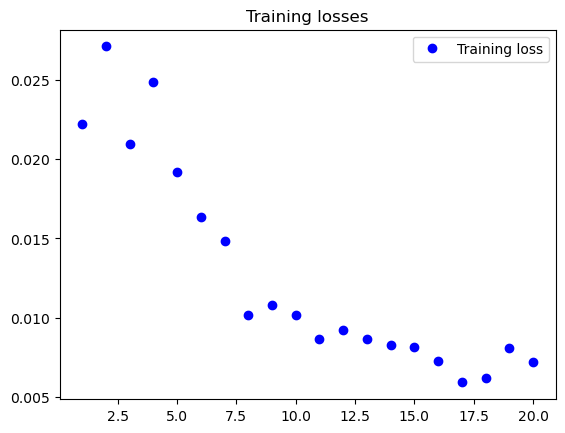

In [34]:
epochs = range(1, len(losses) + 1)
plt.figure()
plt.plot(epochs, losses, 'bo', label='Training loss')
plt.title('Training losses')
plt.legend()
plt.show()

In [35]:
glove.E_l(torch.tensor([100, 10]))[0][:10]

tensor([ 0.0895,  0.0060,  0.1565,  0.0081, -0.3420,  0.0763, -0.1187, -0.2180,
        -0.3365, -0.1595], grad_fn=<SliceBackward0>)

## Embeddings

In [36]:
E = glove.E_l.weight + glove.E_r.weight

In [37]:
E[7:10]

tensor([[ 0.3216, -0.5272,  0.0992,  0.4429,  0.0413, -0.1746, -0.0349,  0.2853,
          0.5304,  0.2046,  0.0828, -0.5230, -0.3811,  0.0020,  0.0070, -0.4216,
         -0.1806,  0.0381, -0.2002,  0.0862, -0.0498,  0.2224,  0.0381,  0.4804,
          1.1353, -0.2203, -1.0726, -0.1812, -0.3523,  0.5714,  0.3017, -0.2291,
          0.6907,  0.0073,  0.2572,  0.7141,  0.0128,  0.5092,  0.3414, -0.0906,
          0.6225,  0.3128, -0.2523,  0.6837,  0.4640,  0.7176,  0.5103,  0.2255,
         -0.1561,  0.0823],
        [ 0.2470, -0.0685,  0.3764,  0.1114, -0.5417, -0.1879, -0.3419,  0.2298,
         -0.4210, -0.0606,  0.1546, -0.7061, -0.1924,  0.3172, -0.0528, -0.2782,
         -0.3297, -0.1986, -0.2204,  0.3649,  0.2832,  0.2817,  0.3574,  0.1630,
          0.1918,  0.4710, -0.3651, -0.5501, -0.3483,  0.2179,  0.3493,  0.2824,
          0.3361,  0.3839,  0.4544, -0.0059, -0.1392,  0.1466,  0.3428, -0.3649,
          0.3490,  0.4252,  0.1596, -0.2220, -0.2397,  0.4829,  0.1631, -0.2200,


In [38]:
test_words

['he',
 'she',
 'ulysses',
 'penelope',
 'achaeans',
 'trojans',
 'achilles',
 'sea',
 'helen',
 'ship',
 'her',
 'fight']

In [39]:
sim_test_words(test_words, word2idx, glove, N=3)

he ['but', 'as', 'was']
she ['her', 'minerva', 'he']
ulysses ['telemachus', 'said', 'achilles']
penelope ['juno', 'queen', 'telemachus']
achaeans ['trojans', 'danaans', 'the']
trojans ['achaeans', 'danaans', 'the']
achilles ['son', 'hector', 'ulysses']
sea ['shore', 'the', 'plain']
helen ['lovely', 'alexandrus', 'herself']
ship ['house', 'board', 'on']
her ['she', 'maids', 'father']
fight ['or', 'trojans', 'let']


In [40]:
df = pd.DataFrame(E.detach().numpy(),
                  index=[idx2word[i] for i in range(len(idx2word))])

In [41]:
df

0         1         2         3         4         5   \
a          0.187510  0.247437 -0.375230 -1.274768  0.921448  0.668151   
abantes   -0.189554 -0.285370  0.854128  0.412294 -0.953125 -0.516262   
abarbarea  0.149930  0.194256  0.065925  0.113331 -0.075552 -0.181553   
abas       0.334942  0.045880  0.223112  0.462320 -0.131836 -0.245427   
abate      0.403290 -0.291222  0.238037  0.721728 -0.239788 -0.393984   
...             ...       ...       ...       ...       ...       ...   
zeal       0.156706 -0.307976  0.699405 -0.336183 -0.412718 -0.122920   
zelea      0.079333  0.384902  0.140737  0.373843 -0.285789 -0.197576   
zephyrus   1.313823  0.077222  0.478152  0.382372 -0.223296 -0.068767   
zethus     0.042413  0.040834  0.300328  0.351278  0.455900 -0.494829   
zeus       0.161259  0.545832  0.136960  0.803435 -0.255128 -0.095559   

                 6         7         8         9   ...        40        41  \
a         -0.821368  0.391937  0.612629 -0.617627  ... -1.209764 -1.061911   
abantes   -0.051423  0.468211 -0.997546 -0.134515  ... -0.166102 -0.052276   
abarbarea -0.224483  0.211869 -0.231421  0.166125  ...  0.287942  0.132046   
abas      -0.190476  0.278024 -0.223887 -0.188514  ...  0.303357  0.192642   
abate      0.304399  0.291595 -0.407638  0.218238  ...  0.043980  0.504329   
...             ...       ...       ...       ...  ...       ...       ...   
zeal      -0.426327 -0.392746 -0.050614  0.035747  ... -0.000490 -0.289587   
zelea     -0.130844  0.201098 -0.121690 -0.005521  ...  0.144649  0.274526   
zephyrus   0.493808 -0.376887 -0.312640 -0.446045  ... -0.505261  0.697693   
zethus    -0.197644  0.206253 -0.363488 -0.200291  ... -0.029048 -0.199901   
zeus      -0.306315  0.055424 -0.366236 -0.410983  ...  0.238347  0.406974   

                 42        43        44        45        46        47  \
a         -0.331261 -0.240655  1.084531 -1.331909 -1.122813  0.775159   
abantes    0.088220  0.306528 -0.298194 -0.003298  0.313713 -0.456380   
abarbarea  0.453750 -0.075494 -0.367252  0.208067  0.478135 -0.274366   
abas       0.361315  0.061024 -0.179763  0.258246  0.229130 -0.162142   
abate     -0.112581 -0.106829 -0.327580  0.202820  0.120177 -0.331303   
...             ...       ...       ...       ...       ...       ...   
zeal      -0.242395 -0.154180  0.112888  0.903388  0.798906 -0.389701   
zelea      0.510073 -0.063815 -0.358085  0.385684  0.040383 -0.049648   
zephyrus  -0.037702  0.180666 -0.441380  0.350257  0.254725  0.024927   
zethus     0.125909 -0.157378 -0.788624  0.624370  0.194212 -0.510571   
zeus       0.132810  0.015086 -0.390784  0.600405  0.669302 -0.249615   

                 48        49  
a         -0.033903 -0.140841  
abantes   -0.521251  0.626748  
abarbarea -0.150318  0.128538  
abas      -0.275331  0.219566  
abate     -0.299474  0.073104  
...             ...       ...  
zeal      -0.267114  0.391546  
zelea     -0.086937  0.120377  
zephyrus   0.923311  0.194467  
zethus     0.165697  0.215114  
zeus      -0.053574  0.464350  

[9768 rows x 50 columns]